In [ ]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm

sys.path.insert(0, '../Modules')
import erqScaling
import erqMedSpec
import os

In [ ]:
# Reading data
smp=Table.read('../LumMatch/LumMatch.fits')
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
rw3_0=smp['r-w3']
rz_0=smp['r-z']
iz_0 = iW3_0 - rw3_0 + rz_0
Lum_0 = smp['Lum']
z_dr12 = smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiber =  smp['FiberID']

In [ ]:
# Normalizing data + getting the center and ERQ
data_0=np.array(list(zip(iW3_0, rew_0)))
(data, minData, rangeData) =  erqScaling.MinMaxScaler(data_0)
Main_center = np.median(data, axis=0)
ERQ = data[((iW3_0>=4.6) & (rew_0>=2))]

enclosing_ratio=0.85; resolution=1000; ngrids=500; 
opening_angle, ERQ_direction = erqMedSpec.opening_angle_finder(ERQ, Main_center, enclosing_ratio, resolution)


#  Obtaining Point A and B for the ERQ wedge
x_erq, y_erq= np.median(ERQ, axis=0)  #center of ERQ population 
r_erq = np.sqrt((x_erq-Main_center[0])**2 + (y_erq-Main_center[1])**2)  # ERQ radius 

A= [0,0]
B= [0,0]
ext=1.6
A[0] = Main_center[0] + r_erq*ext*np.cos(ERQ_direction+opening_angle)
B[0] = Main_center[0] + r_erq*ext*np.cos(ERQ_direction-opening_angle)
A[1] = Main_center[1] + r_erq*ext*np.sin(ERQ_direction+opening_angle)
B[1] = Main_center[1] + r_erq*ext*np.sin(ERQ_direction-opening_angle)

In [ ]:
bw=3 # bandwidth ratio for the default value
wdg=0
dir = 'outData/'
x_erq_0 = (4.6-minData[0])/rangeData[0]
y_erq_0 = (2-minData[1])/rangeData[1]
if os.path.exists(dir)==False:
    os.system('mkdir -p ' + dir)
levels = np.array([0.03, .1, 0.3])
bin_label, bin_pop, tip_label = erqMedSpec.KDE_Bin2D(data, rangeData, minData, x_erq_0, y_erq_0,\
                                          ngrids,  bw, levels, \
                                          A, B, \
                                          True,[1.4,  1.7, 2.2],\
                                          dir+'Bins-ratio-%.2f-bw-%.2f-wdg-%1d.png'\
                                          %(enclosing_ratio, bw, wdg), \
                                          True, '(i-w3-%.2f)/%.2f' %(minData[0], rangeData[0]),'(log10(rew)-%.2f)/%.2f' %(minData[1], rangeData[1]), \
                                          None)

np.savetxt(dir + 'bin_label-wdg-%1d' %(wdg)+'.txt', bin_label)
np.savetxt(dir + 'bin_pop-wdg-%1d' %(wdg) +'.txt', bin_pop)
np.savetxt(dir + 'CentralBinLabel.txt' , tip_label)

In [ ]:
#central bin  Med-Spec
mask = (tip_label==1)
tipSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiber[mask]) 
np.savetxt(dir + 'central-bin-medspec.txt', tipSpec)

In [ ]:
# other bins MedSpec
nBin = 7
for b in range(2,nBin+1):
    mask = (bin_label==b)
    medSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiber[mask])
    np.savetxt(dir +'med-spec-wdg-%d-bin-%d.txt' %(wdg, b-1), medSpec)

In [ ]:
bw=3 # bandwidth ratio for the default value
wdg=2
levels = np.array([0.03, .1, 0.3])

dir = 'outData/'
A= [0,0]
B= [0,0]
ext=-1.
A[0] = Main_center[0] + r_erq*ext*np.cos(ERQ_direction+opening_angle)
B[0] = Main_center[0] + r_erq*ext*np.cos(ERQ_direction-opening_angle)
A[1] = Main_center[1] + r_erq*ext*np.sin(ERQ_direction+opening_angle)
B[1] = Main_center[1] + r_erq*ext*np.sin(ERQ_direction-opening_angle)

# dir = 'outData-cf/'
# if os.path.exists(dir)==False:
#     os.system('mkdir -p ' + dir)
# levels = np.array([0.03, .1, 0.3])
bin_label, bin_pop = erqMedSpec.KDE_Bin2D(data, rangeData, minData,1, 1,\
                                          ngrids,  bw, levels, \
                                          A, B, \
                                          True,[1.4,  1.7, 2.2],\
                                          dir+'Bins-ratio-%.2f-bw-%.2f-wdg-%1d.png'\
                                          %(enclosing_ratio, bw, wdg), \
                                          False, '(i-w3-%.2f)/%.2f' %(minData[0], rangeData[0]),'(log10(rew)-%.2f)/%.2f' %(minData[1], rangeData[1]), \
                                          None)
np.savetxt(dir + 'bin_label-wdg-%1d' %(wdg)+'.txt', bin_label)
np.savetxt(dir + 'bin_pop-wdg-%1d' %(wdg) +'.txt', bin_pop)

In [ ]:
# other bins MedSpec
nBin = 7
for b in range(2,nBin+1):
    mask = (bin_label==b)
    medSpec = erqMedSpec.stacker(z_dr12[mask], plate[mask], mjd[mask], fiber[mask])
    np.savetxt(dir +'med-spec-wdg-%d-bin-%d.txt' %(wdg, b-1), medSpec)

In [ ]:
k

(array([1.86255805, 1.16409878, 1.00888561, 0.5432461 , 0.31042634,
        0.23281976, 0.23281976, 0.15521317, 0.        , 0.07760659]),
 array([1.2495129 , 1.42847824, 1.60744358, 1.78640892, 1.96537426,
        2.1443396 , 2.32330493, 2.50227027, 2.68123561, 2.86020095,
        3.03916629]),
 <a list of 10 Patch objects>)

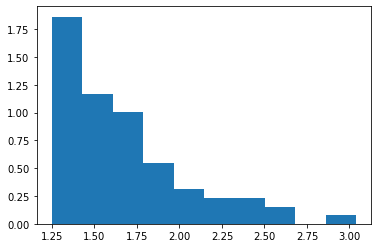

In [4]:
# LOF scores for each bin + Error
dir = 'outData/'
from sklearn.neighbors import LocalOutlierFactor as LOF

nBin=7
clf= LOF(n_neighbors=150,  n_jobs=8)
clf.fit_predict(data)
LOFScores= -clf.negative_outlier_factor_
# plt.hist(LOFScores, density=True)
plt.hist(LOFScores[((iW3_0>=4.6) & (rew_0>=2))], density=True)


  0%|          | 0/29237 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 29237/29237 [00:00<00:00, 34646.45it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/reza/anaconda3/lib/python3.8/s

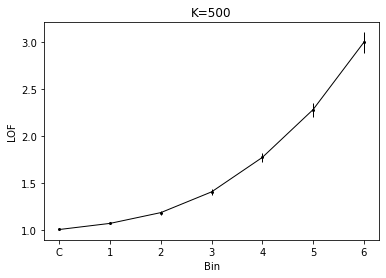

  0%|          | 0/29237 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 29237/29237 [00:00<00:00, 39190.27it/s]
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/reza/anaconda3/lib/python3.8/s

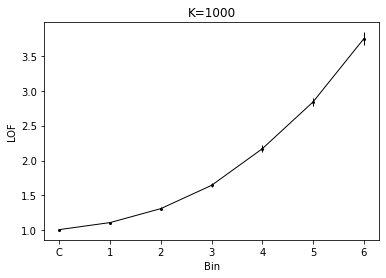

 19%|█▉        | 19/100 [01:44<07:28,  5.54s/it]

In [ ]:
cc=-1
from matplotlib import cm
c = cm.get_cmap('jet',3)

# for k in [50, 100, 150, 200]:
for k in [500, 1000, 1500, 2000]:

    clf= LOF(n_neighbors=k,  n_jobs=8)
    clf.fit_predict(data)
    LOFScores= -clf.negative_outlier_factor_
    BootSize=np.int32(len(data))
    LOFScores_boot=np.zeros([100,len(data)])
    for b in tqdm(range(100)):
        rand_ind = np.random.choice(range(len(data)), BootSize, replace=True)
        test= data[rand_ind,:]
        clf= LOF(n_neighbors=k,  n_jobs=-1)
        clf.fit_predict(test)
        LOFScores_boot[b,rand_ind] = -clf.negative_outlier_factor_
        LOFScores_boot[b,~rand_ind] = 0

    ErrLOF = np.zeros(len(data))
    MeanLOFBoot = np.zeros(len(data))
    for i in tqdm(range(len(data))):

        LOF_pool = LOFScores_boot[:,i]
        ErrLOF[i] = np.std(LOF_pool[LOF_pool>=1])
        # MeanLOFBoot[i] = np.mean(LOF_pool[LOF_pool<=-1])

    LOFScoresMed=[]
    ErrLOFScoresMed=[]
    MeanLOFBootMed=[]
    for wdg in [0,2]:
        bin_label = np.loadtxt(dir + 'bin_label-wdg-%1d' %(wdg)+'.txt')
        bin_pop = np.loadtxt(dir + 'bin_pop-wdg-%1d' %(wdg) +'.txt')
        tip_label = np.loadtxt(dir + 'CentralBinLabel.txt')
        tip_pop= np.sum(tip_label)

        #  Median properties in each bin
        for b in range(1,nBin+1):
            if(b>1):
                mask = (bin_label==b)

            else:
                mask = (tip_label==1)

            LOFScoresMed.append(np.median(LOFScores[mask]))
            ErrLOFScoresMed.append(np.nanmedian(ErrLOF[mask]))
            MeanLOFBootMed.append(np.median(MeanLOFBoot[mask]))


    # plt.plot(['C', '1', '2', '3', '4', '5', '6'], LOFScoresMed[0:nBin], marker='o', lw=2, alpha=0.6, c='C0')
    plt.errorbar(['C', '1', '2', '3', '4', '5', '6'], LOFScoresMed[0:nBin], yerr=ErrLOFScoresMed[0:nBin], c= 'black', marker='o', lw=1,
                 markersize=2, label='k=%d'%k)

# plt.legend()
    plt.xlabel('Bin')
    plt.ylabel('LOF')
    plt.title('K=%d'%k)
    plt.savefig(dir+'LOF-%d.png'%k, dpi=200, format='png')
    plt.show()

In [ ]:
np.nanmedian(ErrLOF[tip_label==1])

In [ ]:
dir = 'outData/'
nBin = 7
for wdg in [0,2]:
    bin_label = np.loadtxt(dir + 'bin_label-wdg-%1d' %(wdg)+'.txt')
    bin_pop = np.loadtxt(dir + 'bin_pop-wdg-%1d' %(wdg) +'.txt')
    tip_label = np.loadtxt(dir + 'CentralBinLabel.txt')
    tip_pop= np.sum(tip_label)
    
    #  Median properties in each bin


    imw3_bin_med =[]
    REW_bin_med = []
    fwhm_bin_med = []
    kt80_bin_med = []
    frat_bin_med = []
    iz_bin_med = []
    Lum_bin_med = []
    BinPop=[]
    LOFScoresMed=[]
    
    for b in range(1,nBin+1):
        if(b>1):
            mask = (bin_label==b)
            BinPop.append(bin_pop[b-1])

        else:
            mask = (tip_label==1)
            BinPop.append(tip_pop)


        imw3_bin_med.append(np.median(iW3_0[mask]))
        REW_bin_med.append(np.median(rew_0[mask]))
        fwhm_bin_med.append(np.median(fwhm_0[mask]))
        kt80_bin_med.append(np.median(kt80_0[mask]))
        frat_bin_med.append(np.median(frat_0[mask]))
        iz_bin_med.append(np.median(iz_0[mask]))
        Lum_bin_med.append(np.median(Lum_0[mask]))
        LOFScoresMed.append(np.median(LOFScores[mask]))

    tabProperties = Table([BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med, LOFScoresMed],
                          
                          names=('nBin', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum', 'LOF'))
    if os.path.exists(dir+ '/wdg-%d-Properties.fits' %(wdg)):
        os.system('rm '+ dir+'/wdg-%d-Properties.fits' %(wdg))
    tabProperties.write(dir+ '/wdg-%d-Properties.fits' %(wdg), format='fits')

#  one table for all wedges
imw3_bin_med =[]
REW_bin_med = []
fwhm_bin_med = []
kt80_bin_med = []
frat_bin_med = []
iz_bin_med = []
Lum_bin_med = []
BinPop=[]
Wedge=[]
binNo=[]
LOFScoresMed=[]
ErrLOFScoresMed=[]
for wdg in [0,2]:
    bin_label = np.loadtxt(dir + 'bin_label-wdg-%1d' %(wdg)+'.txt')
    bin_pop = np.loadtxt(dir + 'bin_pop-wdg-%1d' %(wdg) +'.txt')
    tip_label = np.loadtxt(dir + 'CentralBinLabel.txt')
    tip_pop= np.sum(tip_label)
    from line_db import line_db
    from matplotlib import cm
    from scipy import ndimage

    
    #  Median properties in each bin
    for b in range(1,nBin+1):
        if(b>1):
            mask = (bin_label==b)
            BinPop.append("{0:.0f}".format(bin_pop[b-1]))

        else:
            mask = (tip_label==1)
            BinPop.append("{0:.0f}".format(tip_pop))

        
        imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask])))
        REW_bin_med.append("{0:.0f}".format(np.median(10**rew_0[mask])))
        fwhm_bin_med.append("{0:.0f}".format(np.median(fwhm_0[mask])))
        kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask])))
        frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask])))
        iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask])))
        Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask])))
        Wedge.append("{0:.0f}".format(wdg))
        binNo.append("{0:.0f}".format(b))
        LOFScoresMed.append(np.median(LOFScores[mask]))
        ErrLOFScoresMed.append(np.median(ErrLOF[mask]))

tabProperties = Table([Wedge, binNo, BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med, LOFScoresMed],
                      names=('Wedge','nBin', 'BinPop', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum', 'LOF'))
if os.path.exists(dir+ 'All-Wedge-Properties.fits' ):
    os.system('rm '+ dir+'All-Wedge-Properties.fits' )
tabProperties.write(dir+ 'All-Wedge-Properties.fits' , format='fits')


In [ ]:
#ploting med spec
c = cm.get_cmap('jet', 9)

for ii in range(4):
    c_ind=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,2]:
    # for wdg in [4]:
        bin_label = np.loadtxt(dir + 'bin_label-wdg-%1d' %(wdg)+'.txt')
        bin_pop = np.loadtxt(dir + 'bin_pop-wdg-%1d' %(wdg) +'.txt')
        tip_label = np.loadtxt(dir + 'CentralBinLabel.txt' )
        tip_pop= np.sum(tip_label)
        from line_db import line_db
        from matplotlib import cm
        from scipy import ndimage

   
        ymax=20.5
        ymin=0.02*ymax
        fs=8
        fs1=7
        y_median = 0.95*ymax
        med_step=.8
        legend_loc=7

        # -----------
        step = 1.00015
        bb = np.arange(0,8813,1)
        wgrid = 800.0 * step**bb
        nw = len(bb)


        for b in range(2,nBin+1):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=5):   
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ 'med-spec-wdg-%1d-bin-%1d.txt' %(wdg, b-1))
                plt.ylabel('Normalized Flux')
                plt.xlabel(r'$\lambda  (\AA)$')


                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                else:
                    SmoothedMedSpec = medSpec

                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                if(wdg==0):
                    wdgl=1
                else:
                    wdgl=wdg
                c_ind+=1
                print(c_ind)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 1, c=c(c_ind), 
                             label='W-%d, B-%d #%d' %(wdgl, b-1, bin_pop[b-1]))

    # Bin C med Spec
    medSpec=np.loadtxt(dir+ 'central-bin-medspec.txt')
    plt.plot(wgrid[ind],  medSpec[ind], lw = 3, c='gray', 
                     label='bin-C #%d' %(tip_pop), alpha=0.5)



    plt.legend(loc=7)
#     plt.title('Wedge: %d' %wdg)
    line_db( ymax, fs, fs1, ii) 
    fig_path = dir + 'med-spec-%d-%d.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=200, bbox_inches='tight')
    plt.show()

In [ ]:
c(1)

In [ ]:
#  PLotting  all bin-5  for wedges clos to erq wedge

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ymax=20.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,1,3,4]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

        

        for b in range(5,6):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=4):   
                ci+=1
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
               

                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                
                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                             label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
                

    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-out-bin-5.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [ ]:
#  PLotting  all bin-6  for wedges clos to erq wedge

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ymax=20.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,1,3,4]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

        

        for b in range(6,nBin):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=4):   
                ci+=1
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
               

                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                
                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                             label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
                

    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-out-bin-6.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [ ]:
#  PLotting  all bin-7  for wedges clos to erq wedge

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ymax=20.5
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,1,3,4]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')

        

        for b in range(nBin, nBin+1):
    #     for b in range(len(bin_pop)):
            if(bin_pop[b-1]>=4):   
                ci+=1
                print('bin:', b, lambda_min, 'to', lambda_max)
                medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
               

                if(bin_pop[b-1]<100):
                    SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                
                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                             label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
                

    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-out-bin-7.png'%(lambda_min, lambda_max)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [ ]:
#  PLotting  wedge 0 and 2 in one plot 

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['gray', 'red', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'black']
ymax=20.5
ymin=0.02*ymax
fs=14
fs1=fs
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    # masking for plot ranges
    ind = (wgrid>lambda_min) & (wgrid<lambda_max)
    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0,2]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
        
        for b in range(1,nBin+1):
            
            print('bin:', b, lambda_min, 'to', lambda_max)
            medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
            if(b>1):
                if(bin_pop[b-1]>=5):
                    ci+=1
                    if(bin_pop[b-1]<100):
                        SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                        
                    else:
                        SmoothedMedSpec=medSpec
                        
                    plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = .5, c=c[ci], 
                                 label='wdg-%d, bin-%d #%d' %(wdg, b,  bin_pop[b-1]))
            else:
                if(wdg==0):
                    plt.plot(wgrid[ind],  medSpec[ind], lw =2, c='gray', 
                                     label='wdg-%d, bin-%d #%d' %(wdg, b,  tip_pop))

            
    # plt.legend(loc=7)
    plt.ylabel('Normalized Flux', fontsize=fs)
    plt.xlabel(r'$\lambda  (\AA)$', fontsize=fs)
    line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/med-spec-%d-%d-wdg-0+2.png'%(lambda_min, lambda_max)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [ ]:
dir


In [ ]:
#  PLotting  wedge 0 and 2 in one plot 

tip_label = np.loadtxt(dir + '/tip_label_bw-%.2f' %(bw))
tip_pop= np.sum(tip_label)
from line_db import line_db
from matplotlib import cm
from scipy import ndimage
c=['red', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'black']
ymax=11.2
ymin=0.02*ymax
fs=8
fs1=7
y_median = 0.95*ymax
med_step=.8
legend_loc=7
   # -----------
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nBin=7
for ii in range(4):
    ci=-1
    if(ii==0): lambda_min = 1470; lambda_max = 1600
#     if(ii==1): lambda_min = 1150; lambda_max = 1980
#     if(ii==2): lambda_min = 1150; lambda_max = 2850
#     if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    # masking for plot ranges
    ind = (wgrid>lambda_min) & (wgrid<lambda_max)
    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    x_median=lambda_min+200
    for wdg in [0]:
        bin_label = np.loadtxt(dir + '/bin_label-bw-%.2f-wdg-%1d' %(bw, wdg)+'.txt')
        bin_pop = np.loadtxt(dir + '/bin_pop-bw-%.2f-wdg-%1d' %(bw, wdg) +'.txt')
        
        for b in [1,nBin]:
            
            print('bin:', b, lambda_min, 'to', lambda_max)
            medSpec=np.loadtxt(dir+ '/med-spec-bw-%.2f-wdg-%1d-bin-%1d.txt' %(bw, wdg, b))
            if(b>1):
                if(bin_pop[b-1]>=5):
                    ci+=1
                    if(bin_pop[b-1]<100):
                        SmoothedMedSpec = ndimage.filters.gaussian_filter1d(medSpec,2.0)
                        
                    else:
                        SmoothedMedSpec=medSpec
                        
                    plt.plot(wgrid[ind],  SmoothedMedSpec[ind], lw = 2, c=c[ci], 
                                 label='ERQs')
#             else:
#                 if(wdg==0):
#                     plt.plot(wgrid[ind],  medSpec[ind], lw =2, c='gray', 
#                                      label='Typical QSO')

            
    plt.legend(loc=7)
    plt.ylabel('Normalized Flux')
    plt.xlabel(r'$\lambda  (\AA)$')

#     line_db(ymax, fs, fs1, ii) 
    fig_path = dir + '/c4.png'

    plt.savefig(fig_path, format='png', dpi=800, bbox_inches='tight')
    plt.show()


In [ ]:
# making a table for properties of all wedgs/bins
wedge=[]
Bin=[]
Pop=[]
iw3=[]
rew=[]
fwhm=[]
frat=[]
iz=[]
Lum=[]
kt80=[]
for wdg in [0,1,2,3,4, 10, 20, 100, 200]:
    phys = Table.read(dir+'/wdg-%d-Properties.fits' %wdg)
    for b in range(0,nBin):
        wedge.append(wdg)
        Bin.append(b+1)
        Pop.append(phys['nBin'][b])
        iw3.append(phys['iw3'][b])
        rew.append(phys['rew'][b])
        fwhm.append(phys['fwhm'][b])
        frat.append(phys['frat'][b])
        iz.append(phys['iz'][b])
        Lum.append(phys['Lum'][b])
        kt80.append(phys['kt80'][b])
        
TabAll =Table([np.array(wedge, dtype=np.int16), np.array(nBin, dtype=np.int16)] , #iw3, rew, fwhm, kt80, frat, iz, Lum],
         names=['wedge', 'nBin']) #, 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))

# TabAll.write('TabAll.fits', format='fits')

In [ ]:
phys = np.array(list(zip(wedge, Bin, Pop, iw3, rew, kt80, fwhm, frat, iz, Lum)))

In [ ]:
np.array(Pop, dtype=np.int16)
